In [1]:
import math
import torch as t
import torchvision
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import matplotlib.text as text
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
import random
import logging

In [2]:
if t.cuda.is_available():
  device = t.device("cuda:0")
  print("GPU")
else:
  device = t.device("cpu")
  print("CPU")

GPU


# Classifier and the generator models

In [3]:
# Classifier model is a Resnet model tarined on the MNIST dataset

class ResNet9(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
        )
        self.classifier = nn.Sequential(
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out1 = self.res1(out) + out
        out1 = self.conv3(out1)
        out1 = self.conv4(out1)
        out2 = self.res2(out1) + out1
        out2 = self.classifier(out2)
        return out2

In [4]:
model_classifier = ResNet9()
state_dict = t.load('MNIST_ResNet.pth')
model_classifier.load_state_dict(state_dict)
model_classifier.eval()
model_classifier.to(device)

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv3): Seque

In [5]:
# Let's check!
input = t.rand(10, 1, 28, 28).to(device)
model_classifier(input)

tensor([[ 0.5361, -3.5329,  1.0932, -1.6396, -1.9237, -1.4738, -2.2113, -3.3536,
          3.1382, -1.2460],
        [ 0.2155, -4.1196,  0.9313, -1.0570, -2.4680, -0.9090, -0.6643, -3.8261,
          3.8963, -1.9923],
        [ 0.2521, -2.8239,  2.2606, -2.3675, -0.7223, -1.8662, -1.9893, -2.8940,
          2.7630, -2.5629],
        [ 0.7675, -3.6136,  1.1890, -0.5182, -2.3523, -1.3308, -1.6132, -3.1224,
          3.4825, -2.7732],
        [ 0.4821, -3.7381,  2.5360, -0.9606, -2.3972, -2.2290, -1.1040, -3.2790,
          3.1010, -2.5959],
        [ 0.3253, -3.7254,  1.2590, -2.0857, -2.0579, -1.1042, -1.1028, -3.7346,
          4.0774, -1.9206],
        [ 0.2591, -2.7996,  0.9942, -2.1138, -0.9656, -1.0085, -1.8186, -3.6254,
          3.2057, -1.7049],
        [ 1.4432, -3.6363,  0.4743, -1.0873, -2.3257, -1.6708, -0.8296, -4.5440,
          4.6771, -2.3444],
        [-0.2913, -3.2721,  0.7831, -0.5027, -1.7260, -0.9816, -1.9241, -3.6560,
          3.4524, -1.8630],
        [-0.0256, -

In [100]:
def show_image(image_tensor):
  logger = logging.getLogger() #This part of the code removes the warning message for the matplotlib
  old_level = logger.level
  logger.setLevel(100)
  column = image_tensor.shape[0]
  row = 1
  plt.figure(figsize=(column, row))
  plt.axis('off')
  input = image_tensor.to("cpu")
  output = plt.imshow(make_grid(input, nrow=column).permute((1, 2, 0)))
  logger.setLevel(old_level)
  return output

In [99]:
# Now we design a simple generator model

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.digit_embedding = nn.Embedding(10, 784)
        self.digit_embedding.weight.data.uniform_(0.0, 1.0)
      

    def forward(self, digits):
        out = F.relu(self.digit_embedding(digits))
        out2 = out.reshape(-1, 1, 28, 28)
        return out2

In [102]:
def split(number: str):
    return t.tensor([int(d) for d in number])


split("0123456789")    

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Training

In [42]:
def loss_batch(model_classifier, loss_fn, images, given_labels, opt=None):
    loss = loss_fn(model_classifier(images), given_labels)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item()

def fit(total_epochs, model_classifier, model_generator, loss_fn, opt, seq):
    # each epoch contains 25 cycles of optimization
    t.cuda.empty_cache()
    for epoch in range(total_epochs):
        for cycle in range(25):
            images = model_generator(seq)
            given_labels = seq
            loss_batch(model_classifier, loss_fn, images, given_labels, opt)
        with t.no_grad():
            result = loss_batch(model_classifier, loss_fn, images, given_labels)
            print(f"Epoch [{epoch+1}]: loss = {result:.4f}")
            show_image(images)

Epoch [1]: loss = 0.0581
Epoch [2]: loss = 0.0540
Epoch [3]: loss = 0.0500
Epoch [4]: loss = 0.0497
Epoch [5]: loss = 0.0494
Epoch [6]: loss = 0.0496
Epoch [7]: loss = 0.0497
Epoch [8]: loss = 0.0450
Epoch [9]: loss = 0.0502
Epoch [10]: loss = 0.0494
Epoch [1]: loss = 0.0010
Epoch [2]: loss = 0.0003
Epoch [3]: loss = 0.0003
Epoch [4]: loss = 0.0002
Epoch [5]: loss = 0.0002
Epoch [6]: loss = 0.0002
Epoch [7]: loss = 0.0002
Epoch [8]: loss = 0.0002
Epoch [9]: loss = 0.0002
Epoch [10]: loss = 0.0002


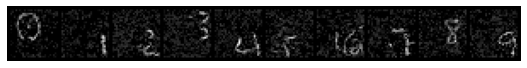

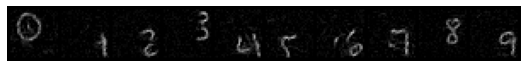

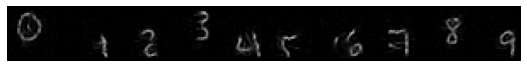

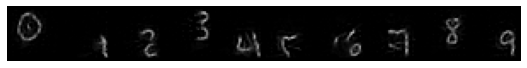

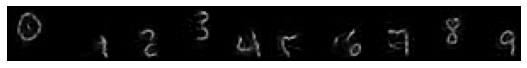

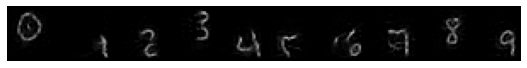

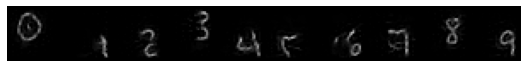

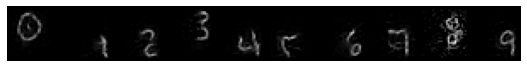

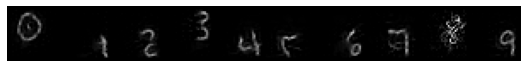

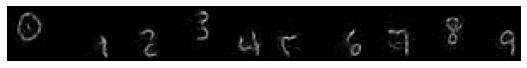

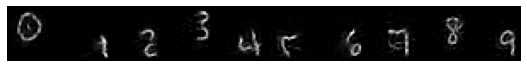

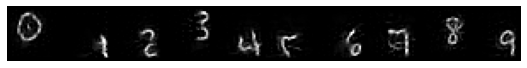

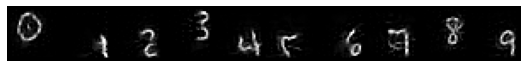

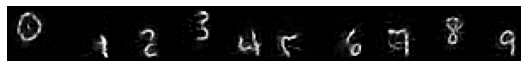

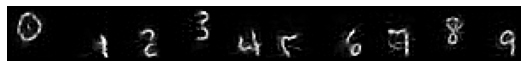

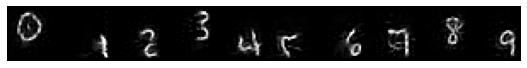

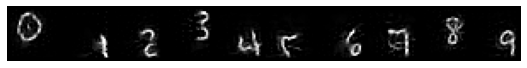

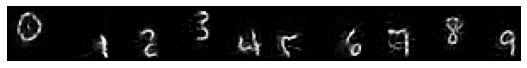

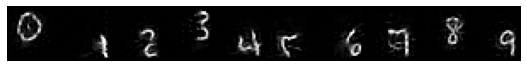

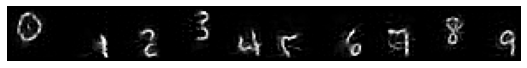

In [104]:
seq = split("0123456789").to(device)
model_generator = Generator().to(device)
loss_fn = F.cross_entropy
opt = t.optim.Adam(model_generator.parameters(), lr=0.2, weight_decay=0.01)
fit(10, model_classifier, model_generator, loss_fn, opt, seq)
opt = t.optim.SGD(model_generator.parameters(), lr=0.5, momentum=0.97)
fit(10, model_classifier, model_generator, loss_fn, opt, seq)

# A writer

In [105]:
def write(number: str):
  input = split(number).to(device)
  with t.no_grad():
    output = show_image(model_generator(input))
  return output

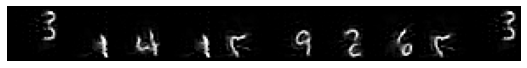

In [106]:
write("3141592653")